# Training LSTM on residuals of physical model

In [ ]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from ode_model import LorenzModel
from lstm import WindowedTimeSeries, train_model, predict_autoregressive

Generate data
- 10,000 obs
- noise proportion = 0.05

In [2]:
n = 10000
noise_level = 0.05
time_step = 0.05

data = generate_data(n, noise_level=noise_level, time_step=time_step)

In [3]:
data.shape

(10000, 3)

Create imperfect Lorenz Model
- Set c = 13 (MSE LSTM aprrox = LSTM ODE)

In [35]:
ode_model = LorenzModel(c=12)

Predict k steps ahead using ODE model
- Compute residuals and inspect

In [36]:
k=10
preds_ode = ode_model.predict(y0=data, t_step=time_step*k)

In [37]:
true = data
true.shape

(10000, 3)

In [38]:
residuals_ode = true[k: , :] - preds_ode[:-k, :]

In [39]:
np.mean(residuals_ode ** 2)

38.98290848428151

In [40]:
np.mean(residuals_ode, axis=0)

array([-0.0461956 , -0.06684681, -0.35986851])

In [41]:
residuals_ode.std(axis=0, ddof=1)

array([7.67795265, 5.90417745, 4.79729542])

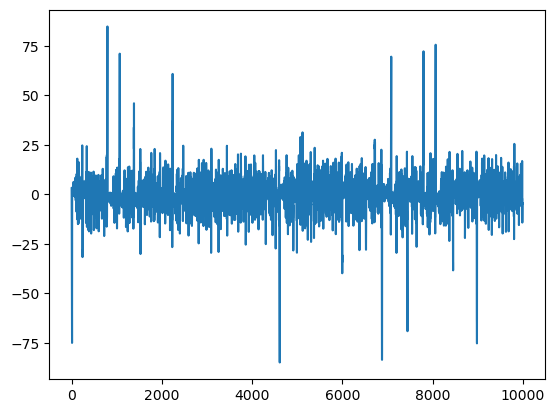

In [42]:
plt.plot(residuals_ode[:,0])
plt.show()

7.860557223250141e-15

Train LSTM
- Split data into train and test
- convert data to custom class
- Train LSTM

In [43]:
train_length = int(residuals_ode.shape[0] * 0.8)
train_series = residuals_ode[:train_length, :]
test_series = residuals_ode[train_length:, :]

In [44]:
train_dataset = WindowedTimeSeries(train_series, 10)
test_dataset = WindowedTimeSeries(test_series, 10)

In [48]:
lstm_model = train_model(
  train_dataset=train_dataset,
  val_dataset=test_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=64,
  learning_rate=0.01,
  num_epochs=20
)

Epoch [10/20], train_loss: 10.9853, val_loss: 15.1998
Epoch [20/20], train_loss: 5.9523, val_loss: 14.8641


LSTM is trained to predict the next residual based on the previous 10, but if we wanted to actually predict k steps in the future we would need the LSTM to autoregressively predict k residuals in the future.

In [50]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [51]:
steps = [1,2,3,4,5,10,15,20]

for step in range(1,21):
  all_preds = []
  all_target = []
  for X_batch, Y_batch in test_loader:
    preds = predict_autoregressive(lstm_model, X_batch, steps=step)
    all_preds.append(preds)
    all_target.append(Y_batch)


  all_preds = torch.cat(all_preds)
  all_target = torch.cat(all_target)
  
  # Corrects allignment due to predicting multiple steps
  if step != 1:
    all_preds = all_preds[:-(step-1), :]
    all_target = all_target[(step-1):, :]

  mse = nn.MSELoss()(all_preds, all_target)
  print(f"{step} Steps, MSE: {mse}")

1 Steps, MSE: 14.864051818847656
2 Steps, MSE: 15.99950885772705
3 Steps, MSE: 18.96085548400879
4 Steps, MSE: 22.68278694152832
5 Steps, MSE: 25.668149948120117
6 Steps, MSE: 28.038299560546875
7 Steps, MSE: 30.146480560302734
8 Steps, MSE: 33.735416412353516
9 Steps, MSE: 38.92932891845703
10 Steps, MSE: 39.266944885253906
11 Steps, MSE: 44.51995849609375
12 Steps, MSE: 46.691402435302734
13 Steps, MSE: 49.011817932128906
14 Steps, MSE: 53.728843688964844
15 Steps, MSE: 52.8751106262207
16 Steps, MSE: 51.911861419677734
17 Steps, MSE: 52.07672119140625
18 Steps, MSE: 54.42359924316406
19 Steps, MSE: 56.72026824951172
20 Steps, MSE: 58.28550720214844
